In [42]:
import baltic as bt
import pandas as pd
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
from datetime import datetime as dt
from datetime import timedelta
import time
#import pymc3
import math
import arviz as az
#from hpd import hpd
import scipy.stats as stats
from io import StringIO
import altair as alt
from altair import datum
alt.data_transformers.disable_max_rows()
import seaborn as sns

from zipfile import ZipFile
import scipy as sp


import sys, subprocess, glob, os, shutil, re, importlib
from subprocess import call
import imp


%matplotlib inline
import matplotlib as mpl
from matplotlib import pyplot as plt
import matplotlib.patheffects as path_effects
import matplotlib.lines as mlines
from matplotlib.font_manager import FontProperties
import matplotlib.colors as clr
from matplotlib import rc
import textwrap as textwrap
from textwrap import wrap


from scipy.special import binom

In [43]:
log_file_path = "/Users/mparedes/Desktop/mpox_rhino/550_glm_region_air_travel.log"


In [44]:
burnin_percent = 0.30

In [14]:
def read_in_Ne_changes_mascot(log_file_path):
    
    Ne_skyline_dict = {"sample":[]}
    
    with open(log_file_path, "r") as infile:
        line_number = 0
        for line in infile:
            line_number += 1
            if not line.startswith("#"):  # log combiner will sometimes put the entire xml at the start of the log file
                # use the first line to find the migration rate columns
                #print(line)
            # use the first line to find the migration rate columns
                if "posterior" in line:
                    all_cols = line.split("\t")
                    Ne_column_indices = []   # list to store column indices
                    Nes_key = {}   # dictionary to store the column index to map to column name

                    for i in range(len(all_cols)):
                        col = all_cols[i]
                        if "Ne." in col:
                            Ne_column_indices.append(i)

                    # make an empty dictionary to store Nes and generate dictionary to convert index to name
                    for n in Ne_column_indices:
                        name = line.split("\t")[n]
                        deme = name.split(".")[1]# the syntax here is "Ne.region.1" where region is deme and 1 is interval 1
                        interval = name.split(".")[2]
                       
                        Nes_key[n] = name
                        Ne_skyline_dict[name] = []


                # read in actual parameter estimates and store in dictionary
                else:
                    sample = line.split("\t")[0]
                    Ne_skyline_dict["sample"].append(sample)

                    for index in Ne_column_indices:
                        name = Nes_key[index]
                        Ne_skyline_dict[name].append(line.split("\t")[index])
                    
                
    return(Ne_skyline_dict)

In [15]:
Ne_skyline = read_in_Ne_changes_mascot(log_file_path)

In [16]:
# make a new dataframe that summarizes the 95% HPD estimate with mean for each deme and interval 
def generate_summary_df(input_df):
    
    
    new_df = pd.DataFrame()

    for i in input_df.columns.tolist():
        if "Ne" in i:
            deme = i.split(".")[1]
            #print(deme)
            interval = i.split(".")[2]
            #print(interval)
            #print(interval)
            #print(i)
            next_interval = int(interval)+1
            local_series = input_df[i].astype('float').to_numpy()
            #print(local_series)
            mean_log = local_series.mean()
            median_log = np.median(local_series)
            mean_linear = 10**mean_log
            hpd_95 = az.hdi(local_series, 0.95)
            lower_hpd_log_95 = hpd_95[0]
            lower_hpd_linear_95 = 10**lower_hpd_log_95
            upper_hpd_log_95 = hpd_95[1]
            upper_hpd_linear_95 = 10**upper_hpd_log_95
            hpd_50 = az.hdi(local_series, 0.50)
            lower_hpd_log_50 = hpd_50[0]
            lower_hpd_linear_50 = 10**lower_hpd_log_50
            upper_hpd_log_50 = hpd_50[1]
            upper_hpd_linear_50 = 10**upper_hpd_log_50
            
            try:
                next_local_series = input_df["Ne"+"."+ str(deme) +"." + str(next_interval)].astype('float').to_numpy()
                diff_series = np.subtract(local_series, next_local_series)
                #print(local_series)
                #print(next_local_series)
                #print(diff_series)
                diff_mean_log = diff_series.mean()
                diff_median_log = np.median(diff_series)
                diff_hpd_95 = az.hdi(diff_series, 0.95)
                diff_lower_hpd_log_95 = diff_hpd_95[0]
                diff_lower_hpd_linear_95 = math.exp(diff_lower_hpd_log_95)
                diff_upper_hpd_log_95 = diff_hpd_95[1]
                diff_upper_hpd_linear_95 = math.exp(diff_upper_hpd_log_95)
                diff_hpd_50 = az.hdi(diff_series, 0.50)
                diff_lower_hpd_log_50 = diff_hpd_50[0]
                diff_lower_hpd_linear_50 = math.exp(diff_lower_hpd_log_50)
                diff_upper_hpd_log_50 = diff_hpd_50[1]
                diff_upper_hpd_linear_50 = math.exp(diff_upper_hpd_log_50)
            except KeyError:
                pass   
            
            try:
                local_df = pd.DataFrame.from_dict({"deme":deme, "interval":interval, "mean_Ne_log":mean_log,"mean_Ne_linear":mean_linear, 
                                                   "median_Ne_log" : median_log, 
                                                   "upper_hpd_log_95":upper_hpd_log_95,"lower_hpd_log_95":[lower_hpd_log_95], 
                                                   "upper_hpd_log_50":upper_hpd_log_50,"lower_hpd_log_50":lower_hpd_log_50,
                                                   "upper_hpd_linear":upper_hpd_linear_95,"lower_hpd_linear":lower_hpd_linear_95,
                                                   "diff_mean_Ne_log":diff_mean_log, "diff_mean_log":diff_mean_log,
                                                   "diff_upper_hpd_log_95":diff_upper_hpd_log_95,"diff_lower_hpd_log_95":diff_lower_hpd_log_95, 
                                                   "diff_upper_hpd_log_50":diff_upper_hpd_log_50,"diff_lower_hpd_log_50":diff_lower_hpd_log_50,
                                                   "diff_upper_hpd_linear":diff_upper_hpd_linear_95,"diff_lower_hpd_linear":diff_lower_hpd_linear_95,
                                                   "diff_upper_hpd_linear_50":diff_upper_hpd_linear_50,"diff_lower_hpd_linear_50":diff_lower_hpd_linear_50})
                new_df = new_df.append(local_df)
                #print(new_df)
            except:
                pass
            
    return(new_df)

In [17]:
Ne_df = pd.DataFrame.from_dict(Ne_skyline)
print(len(Ne_df))
Ne_df

61542


,sample,Ne.CentralEurope.0,Ne.CentralEurope.1,Ne.CentralEurope.2,Ne.CentralEurope.3,Ne.CentralEurope.4,Ne.CentralEurope.5,Ne.CentralEurope.6,Ne.CentralEurope.7,Ne.CentralEurope.8,...,Ne.WesternEurope.29,Ne.WesternEurope.30,Ne.WesternEurope.31,Ne.WesternEurope.32,Ne.WesternEurope.33,Ne.WesternEurope.34,Ne.WesternEurope.35,Ne.WesternEurope.36,Ne.WesternEurope.37,Ne.WesternEurope.38
0,0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,1000,1.965531287767401,1.965531287767401,1.965531287767401,1.965531287767401,1.965531287767401,1.965531287767401,1.965531287767401,1.965531287767401,1.965531287767401,...,1.9414999531024335,1.9414999531024335,1.9414999531024335,1.9414999531024335,1.9414999531024335,1.9414999531024335,1.9414999531024335,1.9414999531024335,1.9414999531024335,1.9414999531024335
2,2000,3.944400250449143,3.944400250449143,3.944400250449143,3.944400250449143,3.944400250449143,3.944400250449143,3.944400250449143,3.944400250449143,3.944400250449143,...,4.051262160054975,4.044264864624885,4.028827797053145,3.990923190015345,3.9435445151626625,3.9435445151626625,3.9435445151626625,3.9435445151626625,3.9435445151626625,3.9435445151626625
3,3000,2.812406529859418,2.812406529859418,2.812406529859418,2.812406529859418,2.812406529859418,2.812406529859418,2.812406529859418,2.812406529859418,2.812406529859418,...,7.043971528204433,6.76289323225102,6.180280903077012,4.946542039580514,3.7335682160549895,3.7335682160549895,3.7335682160549895,3.7335682160549895,3.7335682160549895,3.7335682160549895
4,4000,2.7661389212184475,2.7661389212184475,2.7661389212184475,2.7661389212184475,2.7661389212184475,2.7661389212184475,2.7661389212184475,2.7661389212184475,2.7661389212184475,...,7.311292420666202,7.002830666301034,6.365881670811513,5.029095004467944,3.7338655012798676,3.7338655012798676,3.7338655012798676,3.7338655012798676,3.7338655012798676,3.7338655012798676
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61537,61537000,0.2817847164905922,0.2817847164905922,0.2817847164905922,0.2817847164905922,0.2817847164905922,0.2817847164905922,0.2817847164905922,0.2817847164905922,0.2817847164905922,...,3.518476641037173,3.148172497027055,2.4615795917998486,1.3400406349814853,0.6215312792391129,0.6215312792391129,0.6215312792391129,0.6215312792391129,0.6215312792391129,0.6215312792391129
61538,61538000,0.3144518092596648,0.3144518092596648,0.3144518092596648,0.3144518092596648,0.3144518092596648,0.3144518092596648,0.3144518092596648,0.3144518092596648,0.3144518092596648,...,4.037557625428705,3.6081455401005034,2.8135071209416505,1.5212733399481835,0.6995709963376596,0.6995709963376596,0.6995709963376596,0.6995709963376596,0.6995709963376596,0.6995709963376596
61539,61539000,0.31214563260265554,0.31214563260265554,0.31214563260265554,0.31214563260265554,0.31214563260265554,0.31214563260265554,0.31214563260265554,0.31214563260265554,0.31214563260265554,...,4.050187526682634,3.6170432643181942,2.8163285766675696,1.5173109056992828,0.6945734196099098,0.6945734196099098,0.6945734196099098,0.6945734196099098,0.6945734196099098,0.6945734196099098
61540,61540000,0.32727980956643576,0.32727980956643576,0.32727980956643576,0.32727980956643576,0.32727980956643576,0.32727980956643576,0.32727980956643576,0.32727980956643576,0.32727980956643576,...,3.690645123124899,3.3147534395233813,2.613641408033353,1.452599500313919,0.6916017450681493,0.6916017450681493,0.6916017450681493,0.6916017450681493,0.6916017450681493,0.6916017450681493


In [18]:
ne_summary = generate_summary_df(Ne_df)
ne_summary

/var/folders/h9/0347drb57tsgxzbddmvmlvf80000gp/T/ipykernel_9188/1079060994.py:64: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(local_df)
/var/folders/h9/0347drb57tsgxzbddmvmlvf80000gp/T/ipykernel_9188/1079060994.py:64: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(local_df)
/var/folders/h9/0347drb57tsgxzbddmvmlvf80000gp/T/ipykernel_9188/1079060994.py:64: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(local_df)
/var/folders/h9/0347drb57tsgxzbddmvmlvf80000gp/T/ipykernel_9188/1079060994.py:64: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(local_df)


/var/folders/h9/0347drb57tsgxzbddmvmlvf80000gp/T/ipykernel_9188/1079060994.py:64: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(local_df)
/var/folders/h9/0347drb57tsgxzbddmvmlvf80000gp/T/ipykernel_9188/1079060994.py:64: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(local_df)
/var/folders/h9/0347drb57tsgxzbddmvmlvf80000gp/T/ipykernel_9188/1079060994.py:64: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(local_df)
/var/folders/h9/0347drb57tsgxzbddmvmlvf80000gp/T/ipykernel_9188/1079060994.py:64: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(local_df)


/var/folders/h9/0347drb57tsgxzbddmvmlvf80000gp/T/ipykernel_9188/1079060994.py:64: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(local_df)
/var/folders/h9/0347drb57tsgxzbddmvmlvf80000gp/T/ipykernel_9188/1079060994.py:64: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(local_df)
/var/folders/h9/0347drb57tsgxzbddmvmlvf80000gp/T/ipykernel_9188/1079060994.py:64: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(local_df)
/var/folders/h9/0347drb57tsgxzbddmvmlvf80000gp/T/ipykernel_9188/1079060994.py:64: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(local_df)


/var/folders/h9/0347drb57tsgxzbddmvmlvf80000gp/T/ipykernel_9188/1079060994.py:64: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(local_df)
/var/folders/h9/0347drb57tsgxzbddmvmlvf80000gp/T/ipykernel_9188/1079060994.py:64: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(local_df)
/var/folders/h9/0347drb57tsgxzbddmvmlvf80000gp/T/ipykernel_9188/1079060994.py:64: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(local_df)
/var/folders/h9/0347drb57tsgxzbddmvmlvf80000gp/T/ipykernel_9188/1079060994.py:64: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(local_df)


/var/folders/h9/0347drb57tsgxzbddmvmlvf80000gp/T/ipykernel_9188/1079060994.py:64: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(local_df)
/var/folders/h9/0347drb57tsgxzbddmvmlvf80000gp/T/ipykernel_9188/1079060994.py:64: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(local_df)
/var/folders/h9/0347drb57tsgxzbddmvmlvf80000gp/T/ipykernel_9188/1079060994.py:64: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(local_df)
/var/folders/h9/0347drb57tsgxzbddmvmlvf80000gp/T/ipykernel_9188/1079060994.py:64: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(local_df)


/var/folders/h9/0347drb57tsgxzbddmvmlvf80000gp/T/ipykernel_9188/1079060994.py:64: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(local_df)
/var/folders/h9/0347drb57tsgxzbddmvmlvf80000gp/T/ipykernel_9188/1079060994.py:64: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(local_df)
/var/folders/h9/0347drb57tsgxzbddmvmlvf80000gp/T/ipykernel_9188/1079060994.py:64: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(local_df)
/var/folders/h9/0347drb57tsgxzbddmvmlvf80000gp/T/ipykernel_9188/1079060994.py:64: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(local_df)


,deme,interval,mean_Ne_log,mean_Ne_linear,median_Ne_log,upper_hpd_log_95,lower_hpd_log_95,upper_hpd_log_50,lower_hpd_log_50,upper_hpd_linear,...,diff_mean_Ne_log,diff_mean_log,diff_upper_hpd_log_95,diff_lower_hpd_log_95,diff_upper_hpd_log_50,diff_lower_hpd_log_50,diff_upper_hpd_linear,diff_lower_hpd_linear,diff_upper_hpd_linear_50,diff_lower_hpd_linear_50
0,CentralEurope,0,0.309400,2.038918,0.299916,0.425313,0.200607,0.327501,0.252441,2.662646,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0
0,CentralEurope,1,0.309400,2.038918,0.299916,0.425313,0.200607,0.327501,0.252441,2.662646,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0
0,CentralEurope,2,0.309400,2.038918,0.299916,0.425313,0.200607,0.327501,0.252441,2.662646,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0
0,CentralEurope,3,0.309400,2.038918,0.299916,0.425313,0.200607,0.327501,0.252441,2.662646,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0
0,CentralEurope,4,0.309400,2.038918,0.299916,0.425313,0.200607,0.327501,0.252441,2.662646,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,WesternEurope,34,0.700865,5.021869,0.680612,0.894675,0.498550,0.732564,0.603196,7.846485,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0
0,WesternEurope,35,0.700865,5.021869,0.680612,0.894675,0.498550,0.732564,0.603196,7.846485,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0
0,WesternEurope,36,0.700865,5.021869,0.680612,0.894675,0.498550,0.732564,0.603196,7.846485,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0
0,WesternEurope,37,0.700865,5.021869,0.680612,0.894675,0.498550,0.732564,0.603196,7.846485,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0


In [19]:
test = ne_summary
test['days'] = (test.interval.astype(int)) *7 
test['date'] = dt.strptime("2023-01-03",  "%Y-%m-%d") - test.days.map(timedelta)
#test.date = test.date.astype(str)

In [20]:
domain = ['CentralEurope', 'NorthAmerica', 'SouthAmerica' ,"SouthernEurope", "WesternEurope"]
range_ = ['#EEC060', '#2664A5', '#A76BB1', "#EEA160", "#356D4C"]

In [21]:
line = alt.Chart(test).mark_area(interpolate='monotone').encode(
    alt.X('date:T', axis=alt.Axis(title="", grid=False, format="%B %Y")),
    alt.Y('lower_hpd_log_50',axis=alt.Axis(title="NeTao (/years)", grid=False)),#,scale=alt.Scale(domain=(0, 13))),
    alt.Y2('upper_hpd_log_50' ),
    color=alt.Color('deme:N',  scale=alt.Scale(domain=domain, range=range_))
).properties(
    width=850,
    height=400
)#.transform_filter(
  #  (datum.upper_hpd_log_50 < 50)
#)

band = alt.Chart(test).mark_area(
    opacity=0.3, interpolate='monotone'
).encode(
    alt.X('date:T', axis=alt.Axis(title="", grid=False)),
    alt.Y('lower_hpd_log_95'),#axis=None),#, scale=alt.Scale(domain=(0, 13))),
    alt.Y2('upper_hpd_log_95'),
    color=alt.Color('deme:N', title = "Region", legend=alt.Legend(title= "Region",offset = -170, symbolSize = 150, labelFontSize = 20, titleFontSize = 20))
).properties(
    width=850,
    height=400
)#.transform_filter(
 #   (datum.upper_hpd_log_95 < 50)
#)

ne_plot = line + band
(ne_plot).configure_axis(
    labelFontSize=20,
    titleFontSize=20
)


alt.LayerChart(...)

## now testing the correlation between case counts and Ne

In [22]:
region = {'Canada':'NorthAmerica',
          'United States':'NorthAmerica',
         'Finland':'NorthernEurope',
           'Austria': 'WesternEurope',
        'Germany':'WesternEurope', 
        'Switzerland':'WesternEurope',
         'United Kingdom':'WesternEurope',
        'France':'WesternEurope',
        'Belgium':'WesternEurope',
        'Netherlands':'WesternEurope',
        'Slovakia':'CentralEurope',
        'Slovenia':'CentralEurope',
        'Italy':'SouthernEurope',
        'Portugal':'SouthernEurope',
        'Spain':'SouthernEurope',
         'Colombia':'SouthAmerica',
          
        'Peru':'SouthAmerica'}

In [23]:
raw_cases = pd.read_csv("../case-rt-analysis/data/monkeypox-cases-counts.tsv", sep="\t")
raw_cases["region"] = np.nan
raw_cases.region = raw_cases.location.map(region)
raw_cases = raw_cases.dropna()
raw_cases.date = raw_cases.date.astype('datetime64[ns]')
#weekly_data = raw_cases.groupby("region").resample('W-Wed', label='right', closed = 'right', on='date').sum().reset_index().sort_values(by=["region","date"])    
#weekly_data["d_date"] = weekly_data['date'].astype("str").apply(lambda x:bt.decimalDate(x) )

combined_df = pd.merge(test, raw_cases,  how='left', left_on=['deme','date'], right_on = ['region','date'])
combined_df = combined_df[combined_df.cases >0]
combined_df["log_cases"] = np.log(combined_df.cases)

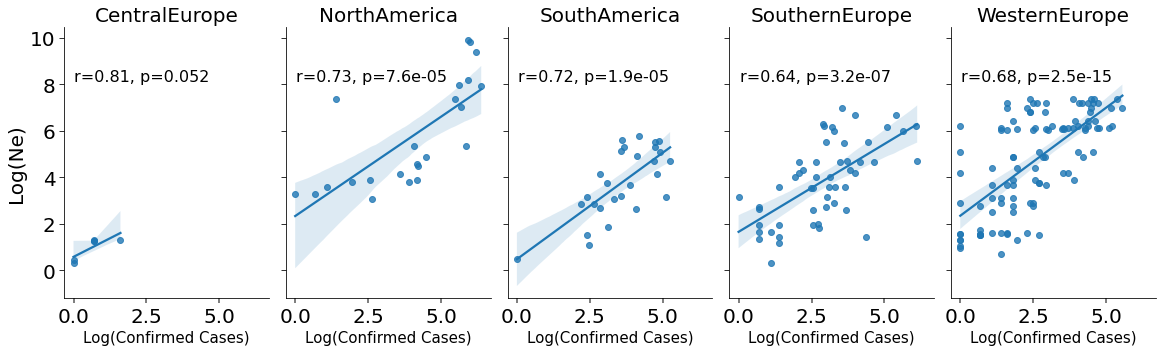

In [24]:
#tips = sns.load_dataset('tips')
g = sns.lmplot(x="log_cases", y="median_Ne_log", data=combined_df,
               col='region', height=5, aspect=0.65)
g.set_titles(col_template="{col_name}", size = 20)

def annotate(data, **kws):
    r, p = sp.stats.pearsonr(data['log_cases'], data['median_Ne_log'])
    ax = plt.gca()
    ax.text(.05, .8, 'r={:.2f}, p={:.2g}'.format(r, p),
            transform=ax.transAxes, size = 16)
    ax.tick_params(axis='y',labelsize=20,size=5)
    ax.tick_params(axis='x',labelsize=20,size=5, width=2,color='grey')
    ax.set_ylabel("Log(Ne)" , size=20)
    ax.set_xlabel("Log(Confirmed Cases)" , size=15)
    
g.map_dataframe(annotate)

plt.savefig('../figures/ne_case_correlation.png',dpi=300,bbox_inches='tight')

plt.show()

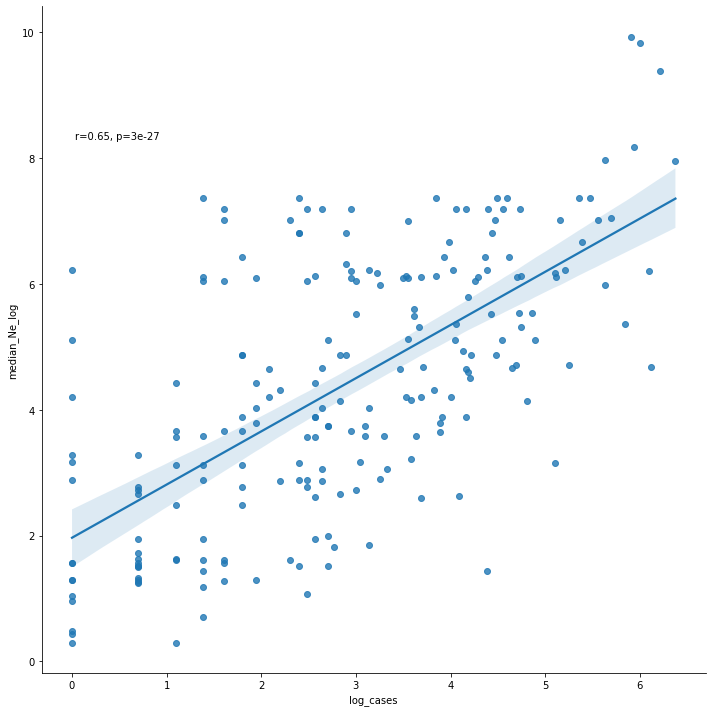

In [25]:
g = sns.lmplot(x="log_cases", y="median_Ne_log", data=combined_df,
                height=10, aspect=1)

def annotate(data, **kws):
    r, p = sp.stats.pearsonr(data['log_cases'], data['median_Ne_log'])
    ax = plt.gca()
    ax.text(.05, .8, 'r={:.2f}, p={:.2g}'.format(r, p),
            transform=ax.transAxes)
    
g.map_dataframe(annotate)
plt.show()

In [26]:
case_prevalence = pd.read_csv("../case-rt-analysis/estimates/case-prevalence-estimates_region.tsv", sep="\t", parse_dates= ["date"])
case_prevalence
case_prevalence["log_median"] = np.log(case_prevalence.median_prev)
case_prevalence["log_upper_95"] = np.log(case_prevalence.prev_upper_95)
case_prevalence["log_lower_95"] = np.log(case_prevalence.prev_lower_95)
case_prevalence.region = case_prevalence.region.replace({"North America": "NorthAmerica", "Western Europe": "WesternEurope", "Central Europe":"CentralEurope", "South America":"SouthAmerica", "Southern Europe": "SouthernEurope"})
case_prevalence

,date,region,median_prev,prev_upper_95,prev_lower_95,log_median,log_upper_95,log_lower_95
0,2022-05-07,WesternEurope,7.585474,10.701495,5.469631e+00,2.026235,2.370383,1.699211
1,2022-05-08,WesternEurope,9.244686,12.735924,7.002571e+00,2.224049,2.544427,1.946277
2,2022-05-09,WesternEurope,10.968780,14.913989,8.422624e+00,2.395053,2.702300,2.130921
3,2022-05-10,WesternEurope,12.689804,17.026270,9.843614e+00,2.540799,2.834757,2.286823
4,2022-05-11,WesternEurope,14.382357,19.200950,1.126665e+01,2.666002,2.954960,2.421847
...,...,...,...,...,...,...,...,...
1217,2023-01-22,CentralEurope,0.000010,0.013220,5.845951e-09,-11.520864,-4.326032,-18.957517
1218,2023-01-23,CentralEurope,0.000009,0.013524,4.850301e-09,-11.652218,-4.303269,-19.144225
1219,2023-01-24,CentralEurope,0.000008,0.014184,3.982427e-09,-11.754263,-4.255672,-19.341374
1220,2023-01-25,CentralEurope,0.000007,0.014906,3.212473e-09,-11.835260,-4.205961,-19.556225


In [27]:
band3 = alt.Chart(case_prevalence).mark_area(interpolate='monotone', opacity = 0.3 ,color = "#f58518").encode(
    alt.X('date:T', axis=alt.Axis(title="", grid=False,format="%B %Y")),
    alt.Y('prev_lower_95',axis=alt.Axis(title="Estimated Prevalence (# of cases)", grid=False)),# scale=alt.Scale(domain=(0.6, 1.3))),
    alt.Y2('prev_upper_95' ),
    alt.Color("region:N",legend=alt.Legend(title= "Region",offset = -170, symbolSize = 150, labelFontSize = 20, titleFontSize = 20),  scale=alt.Scale(domain=domain, range=range_))
).properties(
    width=850,
    height=300)

line3 = alt.Chart(case_prevalence).mark_line(
    opacity=1, interpolate='monotone', color = "#f58518"
).encode(
    alt.X('date:T', axis=alt.Axis(title="", grid=False)),
    alt.Y('median_prev', axis=alt.Axis(title="", grid=False)),# scale=alt.Scale(domain=(0.6, 1.3))), 
    alt.Color("region:N",  scale=alt.Scale(domain=domain, range=range_))
).properties(
    width=850,
    height=300)

case_prev_plot = band3 + line3
case_prev_plot

alt.LayerChart(...)

In [28]:
combined_ne_prev_df = pd.merge(test, case_prevalence,  how='left', left_on=['deme','date'], right_on = ['region','date'])
combined_ne_prev_df = combined_ne_prev_df.dropna()
combined_ne_prev_df


,deme,interval,mean_Ne_log,mean_Ne_linear,median_Ne_log,upper_hpd_log_95,lower_hpd_log_95,upper_hpd_log_50,lower_hpd_log_50,upper_hpd_linear,...,diff_lower_hpd_linear_50,days,date,region,median_prev,prev_upper_95,prev_lower_95,log_median,log_upper_95,log_lower_95
0,CentralEurope,0,0.309400,2.038918,0.299916,0.425313,0.200607,0.327501,0.252441,2.662646,...,1.000000,0,2023-01-03,CentralEurope,0.000055,0.017915,1.835873e-07,-9.816431,-4.022098,-15.510576
1,CentralEurope,1,0.309400,2.038918,0.299916,0.425313,0.200607,0.327501,0.252441,2.662646,...,1.000000,7,2022-12-27,CentralEurope,0.000109,0.018240,4.732231e-07,-9.124873,-4.004123,-14.563699
2,CentralEurope,2,0.309400,2.038918,0.299916,0.425313,0.200607,0.327501,0.252441,2.662646,...,1.000000,14,2022-12-20,CentralEurope,0.000205,0.021571,1.383081e-06,-8.490561,-3.836408,-13.491197
3,CentralEurope,3,0.309400,2.038918,0.299916,0.425313,0.200607,0.327501,0.252441,2.662646,...,1.000000,21,2022-12-13,CentralEurope,0.000375,0.025233,4.036790e-06,-7.889133,-3.679615,-12.420061
4,CentralEurope,4,0.309400,2.038918,0.299916,0.425313,0.200607,0.327501,0.252441,2.662646,...,1.000000,28,2022-12-06,CentralEurope,0.000744,0.031162,1.223185e-05,-7.203656,-3.468553,-11.311468
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
186,WesternEurope,30,3.922142,8358.770495,3.740138,4.763563,2.826010,3.981867,3.381129,58018.088135,...,2.107532,210,2022-06-07,WesternEurope,225.248370,253.237560,2.023182e+02,5.417204,5.534328,5.309841
187,WesternEurope,31,3.015139,1035.472992,2.889012,3.649260,2.228748,3.075185,2.633385,4459.234516,...,3.370280,217,2022-05-31,WesternEurope,128.108950,145.531020,1.133180e+02,4.852881,4.980389,4.730198
188,WesternEurope,32,1.578513,37.889021,1.524347,1.919373,1.186867,1.620101,1.385789,83.056393,...,2.161150,224,2022-05-24,WesternEurope,64.227066,75.282780,5.488403e+01,4.162425,4.321251,4.005222
189,WesternEurope,33,0.700865,5.021869,0.680612,0.894675,0.498550,0.732564,0.603196,7.846485,...,1.000000,231,2022-05-17,WesternEurope,28.836319,36.331005,2.390174e+01,3.361636,3.592672,3.173951


In [29]:
line = alt.Chart(combined_ne_prev_df).mark_area(interpolate='monotone').encode(
    alt.X('date:T', axis=alt.Axis(title="Date", grid=False, format="%B %Y")),
    alt.Y('lower_hpd_log_50',axis=alt.Axis(title="Ne_tao", grid=False)),#,scale=alt.Scale(domain=(0, 13))),
    alt.Y2('upper_hpd_log_50' )
).properties(
    width=500,
    height=300
)#.transform_filter(
  #  (datum.upper_hpd_log_50 < 50)
#)

band = alt.Chart(combined_ne_prev_df).mark_area(
    opacity=0.3, interpolate='monotone'
).encode(
    alt.X('date:T', axis=alt.Axis(title="Date", grid=False)),
    alt.Y('lower_hpd_log_95'),#axis=None),#, scale=alt.Scale(domain=(0, 13))),
    alt.Y2('upper_hpd_log_95')
).properties(
    width=500,
    height=300
)#.transform_filter(
 #   (datum.upper_hpd_log_95 < 50)
#)

ne_plot = line + band
#ne_plot

In [30]:
band3 = alt.Chart(combined_ne_prev_df).mark_area(interpolate='monotone', opacity = 0.3 ,color = "#f58518").encode(
    alt.X('date:T', axis=alt.Axis(title="Date", grid=False,format="%B %Y")),
    alt.Y('log_lower_95',axis=alt.Axis(title="Estimated Log Prevalence", grid=False)),# scale=alt.Scale(domain=(0.6, 1.3))),
    alt.Y2('log_upper_95' )
).properties(
    width=500,
    height=300)

line3 = alt.Chart(combined_ne_prev_df).mark_line(
    opacity=1, interpolate='monotone', color = "#f58518"
).encode(
    alt.X('date:T', axis=alt.Axis(title="Date", grid=False)),
    alt.Y('log_median', axis=alt.Axis(title="", grid=False))
).properties(
    width=500,
    height=300)

case_prev_plot = band3 + line3
#case_prev_plot

In [31]:

alt.concat(*(
    alt.layer(ne_plot, case_prev_plot, title=f"Region = {val}").transform_filter(alt.datum.region == val).resolve_scale(y='shared')
    for val in combined_ne_prev_df.region.unique() if val != np.nan
))

alt.ConcatChart(...)

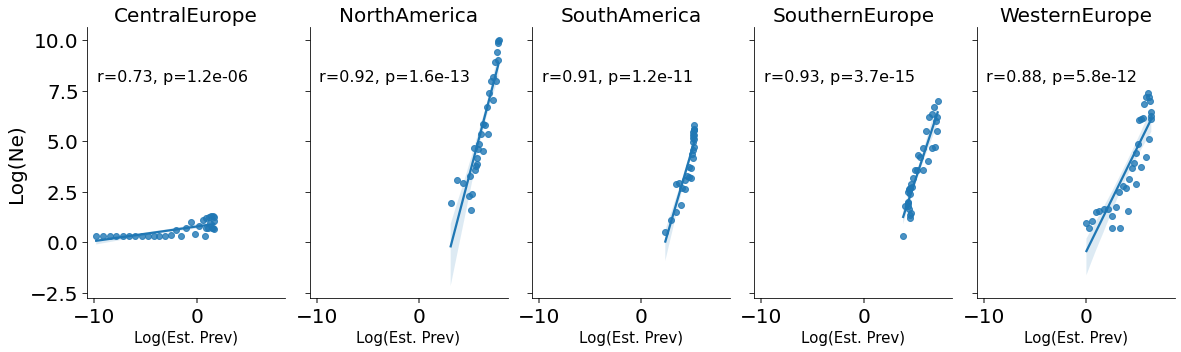

In [32]:

#tips = sns.load_dataset('tips')
g = sns.lmplot(x="log_median", y="median_Ne_log", data=combined_ne_prev_df,
               col='region', height=5, aspect=0.65)
g.set_titles(col_template="{col_name}", size = 20)

def annotate(data, **kws):
    r, p = sp.stats.pearsonr(data['log_median'], data['median_Ne_log'])
    ax = plt.gca()
    ax.text(.05, .8, 'r={:.2f}, p={:.2g}'.format(r, p),
            transform=ax.transAxes, size = 16)
    ax.tick_params(axis='y',labelsize=20,size=5)
    ax.tick_params(axis='x',labelsize=20,size=5, width=2,color='grey')
    ax.set_ylabel("Log(Ne)" , size=20)
    ax.set_xlabel("Log(Est. Prev)" , size=15)
    
g.map_dataframe(annotate)

plt.savefig('../figures/550_glm_region_ne_prev_corr.png',dpi=300,bbox_inches='tight')

plt.show()

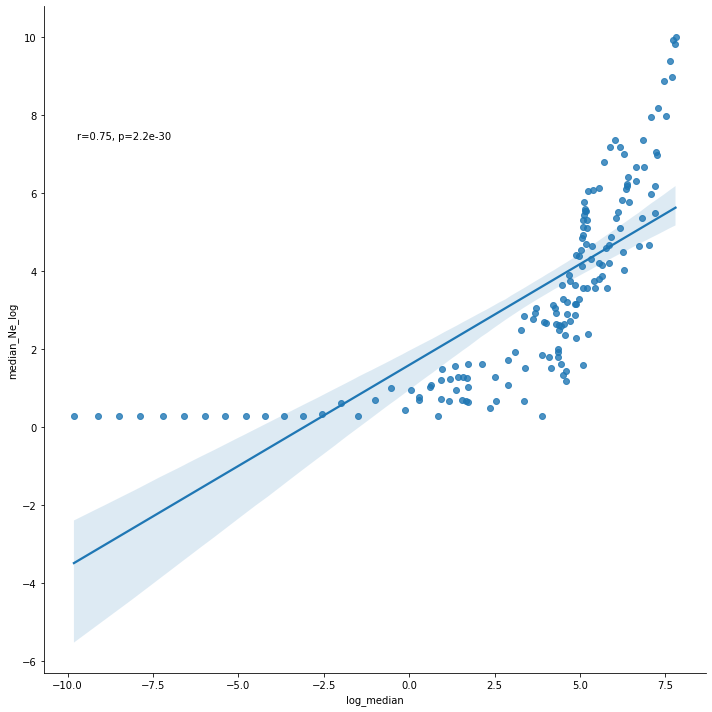

In [33]:
g = sns.lmplot(x="log_median", y="median_Ne_log", data=combined_ne_prev_df,
                height=10, aspect=1)

def annotate(data, **kws):
    r, p = sp.stats.pearsonr(data['log_median'], data['median_Ne_log'])
    ax = plt.gca()
    ax.text(.05, .8, 'r={:.2f}, p={:.2g}'.format(r, p),
            transform=ax.transAxes)
    
g.map_dataframe(annotate)
plt.show()

In [34]:
combined_ne_prev_df["ne_div_tao_median"] = combined_ne_prev_df.median_Ne_log.div(12.6/365)
combined_ne_prev_df["ne_div_tao_upper_95"] = combined_ne_prev_df.upper_hpd_log_95.div(12.6/365)
combined_ne_prev_df["ne_div_tao_lower_95"] = combined_ne_prev_df.lower_hpd_log_95.div(12.6/365)
combined_ne_prev_df

,deme,interval,mean_Ne_log,mean_Ne_linear,median_Ne_log,upper_hpd_log_95,lower_hpd_log_95,upper_hpd_log_50,lower_hpd_log_50,upper_hpd_linear,...,region,median_prev,prev_upper_95,prev_lower_95,log_median,log_upper_95,log_lower_95,ne_div_tao_median,ne_div_tao_upper_95,ne_div_tao_lower_95
0,CentralEurope,0,0.309400,2.038918,0.299916,0.425313,0.200607,0.327501,0.252441,2.662646,...,CentralEurope,0.000055,0.017915,1.835873e-07,-9.816431,-4.022098,-15.510576,8.688049,12.320589,5.811238
1,CentralEurope,1,0.309400,2.038918,0.299916,0.425313,0.200607,0.327501,0.252441,2.662646,...,CentralEurope,0.000109,0.018240,4.732231e-07,-9.124873,-4.004123,-14.563699,8.688049,12.320589,5.811238
2,CentralEurope,2,0.309400,2.038918,0.299916,0.425313,0.200607,0.327501,0.252441,2.662646,...,CentralEurope,0.000205,0.021571,1.383081e-06,-8.490561,-3.836408,-13.491197,8.688049,12.320589,5.811238
3,CentralEurope,3,0.309400,2.038918,0.299916,0.425313,0.200607,0.327501,0.252441,2.662646,...,CentralEurope,0.000375,0.025233,4.036790e-06,-7.889133,-3.679615,-12.420061,8.688049,12.320589,5.811238
4,CentralEurope,4,0.309400,2.038918,0.299916,0.425313,0.200607,0.327501,0.252441,2.662646,...,CentralEurope,0.000744,0.031162,1.223185e-05,-7.203656,-3.468553,-11.311468,8.688049,12.320589,5.811238
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
186,WesternEurope,30,3.922142,8358.770495,3.740138,4.763563,2.826010,3.981867,3.381129,58018.088135,...,WesternEurope,225.248370,253.237560,2.023182e+02,5.417204,5.534328,5.309841,108.345260,137.992115,81.864589
187,WesternEurope,31,3.015139,1035.472992,2.889012,3.649260,2.228748,3.075185,2.633385,4459.234516,...,WesternEurope,128.108950,145.531020,1.133180e+02,4.852881,4.980389,4.730198,83.689644,105.712700,64.562943
188,WesternEurope,32,1.578513,37.889021,1.524347,1.919373,1.186867,1.620101,1.385789,83.056393,...,WesternEurope,64.227066,75.282780,5.488403e+01,4.162425,4.321251,4.005222,44.157680,55.600886,34.381462
189,WesternEurope,33,0.700865,5.021869,0.680612,0.894675,0.498550,0.732564,0.603196,7.846485,...,WesternEurope,28.836319,36.331005,2.390174e+01,3.361636,3.592672,3.173951,19.716144,25.917177,14.442111


In [35]:
alt.Chart(combined_ne_prev_df).mark_line(
    opacity=1, interpolate='monotone', color = "#f58518"
).encode(
    alt.X('date:T', axis=alt.Axis(title="Date", grid=False)),
    alt.Y('ne_div_tao_median', axis=alt.Axis(title="Ne", grid=False)),
    #alt.Y("log_median"),
    alt.Color("deme:N")
).properties(
    width=800,
    height=400)

alt.Chart(...)

In [36]:
alt.Chart(combined_ne_prev_df).mark_line(
    opacity=1, interpolate='monotone', color = "#f58518"
).encode(
    alt.X('date:T', axis=alt.Axis(title="Date", grid=False)),
    alt.Y('median_prev', axis=alt.Axis(title="prev", grid=False)),
    #alt.Y("log_median"),
    alt.Color("deme:N")
).properties(
    width=800,
    height=400)

alt.Chart(...)

In [37]:

# group by 'Group' and find the maximum value for each group
max_values = combined_ne_prev_df.groupby('deme')['ne_div_tao_median'].max()

# identify the entire row that coincides with the maximum value by group
for group, max_val in max_values.iteritems():
    max_idx = combined_ne_prev_df.loc[combined_ne_prev_df.loc[combined_ne_prev_df['deme'] == group]['ne_div_tao_median'].idxmax()].name
    max_row = combined_ne_prev_df.loc[max_idx]
    print(f"Max value for group {group}: {max_val} (on date {max_row['date']})")


Max value for group CentralEurope: 37.51976308172198 (on date 2022-08-02 00:00:00)
Max value for group NorthAmerica: 290.0805558169926 (on date 2022-08-23 00:00:00)
Max value for group SouthAmerica: 167.5372987638635 (on date 2022-10-04 00:00:00)
Max value for group SouthernEurope: 202.54423946054462 (on date 2022-07-19 00:00:00)
Max value for group WesternEurope: 213.493038974694 (on date 2022-08-02 00:00:00)


In [38]:
# group by 'Group' and find the maximum value for each group
max_values = combined_ne_prev_df.groupby('deme')['median_prev'].max()

# identify the entire row that coincides with the maximum value by group
for group, max_val in max_values.iteritems():
    max_idx = combined_ne_prev_df.loc[combined_ne_prev_df.loc[combined_ne_prev_df['deme'] == group]['median_prev'].idxmax()].name
    max_row = combined_ne_prev_df.loc[max_idx]
    print(f"Max value for group {group}: {max_val} (on date {max_row['date']})")

Max value for group CentralEurope: 5.644026 (on date 2022-07-12 00:00:00)
Max value for group NorthAmerica: 2425.2788 (on date 2022-08-23 00:00:00)
Max value for group SouthAmerica: 181.68954 (on date 2022-09-06 00:00:00)
Max value for group SouthernEurope: 1403.0249 (on date 2022-07-19 00:00:00)
Max value for group WesternEurope: 599.6135 (on date 2022-07-05 00:00:00)


In [39]:
combined_ne_prev_df["n_div_ne_median"] = combined_ne_prev_df.median_prev/combined_ne_prev_df.ne_div_tao_median
combined_ne_prev_df["n_div_ne_median_upper_95"] = combined_ne_prev_df.prev_upper_95/combined_ne_prev_df.ne_div_tao_upper_95
combined_ne_prev_df["n_div_ne_median_lower_95"] = combined_ne_prev_df.prev_lower_95/combined_ne_prev_df.ne_div_tao_lower_95

combined_ne_prev_df

,deme,interval,mean_Ne_log,mean_Ne_linear,median_Ne_log,upper_hpd_log_95,lower_hpd_log_95,upper_hpd_log_50,lower_hpd_log_50,upper_hpd_linear,...,prev_lower_95,log_median,log_upper_95,log_lower_95,ne_div_tao_median,ne_div_tao_upper_95,ne_div_tao_lower_95,n_div_ne_median,n_div_ne_median_upper_95,n_div_ne_median_lower_95
0,CentralEurope,0,0.309400,2.038918,0.299916,0.425313,0.200607,0.327501,0.252441,2.662646,...,1.835873e-07,-9.816431,-4.022098,-15.510576,8.688049,12.320589,5.811238,0.000006,0.001454,3.159176e-08
1,CentralEurope,1,0.309400,2.038918,0.299916,0.425313,0.200607,0.327501,0.252441,2.662646,...,4.732231e-07,-9.124873,-4.004123,-14.563699,8.688049,12.320589,5.811238,0.000013,0.001480,8.143241e-08
2,CentralEurope,2,0.309400,2.038918,0.299916,0.425313,0.200607,0.327501,0.252441,2.662646,...,1.383081e-06,-8.490561,-3.836408,-13.491197,8.688049,12.320589,5.811238,0.000024,0.001751,2.380011e-07
3,CentralEurope,3,0.309400,2.038918,0.299916,0.425313,0.200607,0.327501,0.252441,2.662646,...,4.036790e-06,-7.889133,-3.679615,-12.420061,8.688049,12.320589,5.811238,0.000043,0.002048,6.946523e-07
4,CentralEurope,4,0.309400,2.038918,0.299916,0.425313,0.200607,0.327501,0.252441,2.662646,...,1.223185e-05,-7.203656,-3.468553,-11.311468,8.688049,12.320589,5.811238,0.000086,0.002529,2.104860e-06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
186,WesternEurope,30,3.922142,8358.770495,3.740138,4.763563,2.826010,3.981867,3.381129,58018.088135,...,2.023182e+02,5.417204,5.534328,5.309841,108.345260,137.992115,81.864589,2.078987,1.835160,2.471376e+00
187,WesternEurope,31,3.015139,1035.472992,2.889012,3.649260,2.228748,3.075185,2.633385,4459.234516,...,1.133180e+02,4.852881,4.980389,4.730198,83.689644,105.712700,64.562943,1.530762,1.376665,1.755156e+00
188,WesternEurope,32,1.578513,37.889021,1.524347,1.919373,1.186867,1.620101,1.385789,83.056393,...,5.488403e+01,4.162425,4.321251,4.005222,44.157680,55.600886,34.381462,1.454494,1.353985,1.596326e+00
189,WesternEurope,33,0.700865,5.021869,0.680612,0.894675,0.498550,0.732564,0.603196,7.846485,...,2.390174e+01,3.361636,3.592672,3.173951,19.716144,25.917177,14.442111,1.462574,1.401812,1.655003e+00


In [40]:
band4 = alt.Chart(combined_ne_prev_df).mark_area(interpolate='monotone', opacity = 0.3 ,color = "#f58518").encode(
    alt.X('date:T', axis=alt.Axis(title="Date", grid=False,format="%B %Y")),
    alt.Y('n_div_ne_median_lower_95',axis=alt.Axis(title="", grid=False)),# scale=alt.Scale(domain=(0.6, 1.3))),
    alt.Y2('n_div_ne_median_upper_95' ),
    alt.Color("deme:N",legend=alt.Legend(title= "Region",offset = -120, labelFontSize = 12, titleFontSize = 12),  scale=alt.Scale(domain=domain, range=range_))
).properties(
    width=850,
    height=300)

line4 =alt.Chart(combined_ne_prev_df).mark_line(
    opacity=1, interpolate='monotone', color = "#f58518"
).encode(
    alt.X('date:T', axis=alt.Axis(title="", grid=False)),
    alt.Y('n_div_ne_median', axis=alt.Axis(title="N/Ne", grid=False)), 
    alt.Color("deme")
).properties(
    width=800,
    height=400).transform_filter(
    (datum.n_div_ne_median <18) & (datum.n_div_ne_median >0)
)

n_ne_ratio = band4+line4
n_ne_ratio

alt.LayerChart(...)

In [41]:
# Add labels to each chart
ne_plot = ne_plot.properties(title='B')
case_prev_plot = case_prev_plot.properties(title='C')
n_ne_ratio = n_ne_ratio.properties(title='D')

combined_plot = alt.vconcat(ne_plot, case_prev_plot,n_ne_ratio,  spacing=50).resolve_scale(x='shared', color ='shared')


combined_plot.configure_view(
    strokeWidth=0
).configure_title(
    anchor='start', fontSize= 35
).configure_axis(
    labelFontSize=22,
    titleFontSize=22
)

alt.VConcatChart(...)

## plot regional tree reconstruction from mascot glm mcc tree

In [2]:
def convertDate(x,start,end):
    """ Converts calendar dates between given formats """
    return dt.strftime(dt.strptime(x,start),end)

In [3]:
# set path to tree to load 
tree_path = "/Users/mparedes/Desktop/mpox_rhino/550_glm_region_air_mcc.tree"

In [4]:
# load trees
tree = bt.loadNexus(tree_path, tip_regex='_([0-9\-]+)$')
tree.setAbsoluteTime(2023.0068)

In [5]:
all_geos = []

for k in tree.Objects: 
    if k.branchType=='node':
        #print(k.traits)
        division = k.traits['max']
        all_geos.append(division)
print(set(all_geos))

{'CentralEurope', 'SouthernEurope', 'NorthAmerica', 'WesternEurope', 'SouthAmerica'}


In [6]:
# add together probabilities for divisions in the same regions

# parse leaf and node information into a dictionary for plotting
metadata = {}
node_types = {}
node_probs = {}
pos_support = []


for k in tree.Objects: ## iterate over objects in tree
    if k.branchType=='leaf':
        division = k.traits['max']
        #region = regions[division]
        metadata[k] = {}
        metadata[k]["division"] = division
        #metadata[k]["region"] = region
        node_probs[k] = k.traits["max.prob"]  # for a leaf, this is always 1.0
    
    # parse the nodes now and pick out the type trait
    if k.branchType=='node':
        node_division = k.traits["max"]
        division_prob = k.traits["max.prob"]
        
        #node_region = regions[node_division]       
        geo_set = k.traits['max.set']
        geo_set_prob = k.traits['max.set.prob']
        
        node_prob = 0
        for i in range(len(geo_set)):
            division = geo_set[i]
            #region = regions[division]
            geo_prob = geo_set_prob[i]
            
            #if region == node_region:
            node_prob += geo_prob
        
        
        node_types[k] = {}
        node_types[k]["division"] = node_division
        #node_types[k]["region"] = node_region 
        node_probs[k] = division_prob
        pos_support.append(k.traits["posterior"])

        #division_probs[k] = division_prob
        #print(node_probs[k])

In [7]:


#region = {('Canada','USA'):'North America',
#          'Finland':'Northern Europe',
#          ('Austria','Germany','Switzerland','UnitedKingdom','France','Belgium','Netherlands'):'Western Europe', 
#          ('Slovakia','Slovenia'):'Central/Eastern Europe',
#          ('Italy','Portugal','Spain'):'Southern Europe',
#          ('Colombia','Peru'):'South America'}



colors = {"CentralEurope":"#D0A854",
          "NorthAmerica":"#2664A5",
          "SouthAmerica":"#A76BB1",
          "SouthernEurope":"#D07954",
          "WesternEurope":"#356D4C",
          "ancestor": "#B9B9B9"
         }

uncertainty_color = "#B9B9B9"

division_order = [ 'NorthAmerica', "WesternEurope", 'CentralEurope', "SouthernEurope", 'SouthAmerica' ]

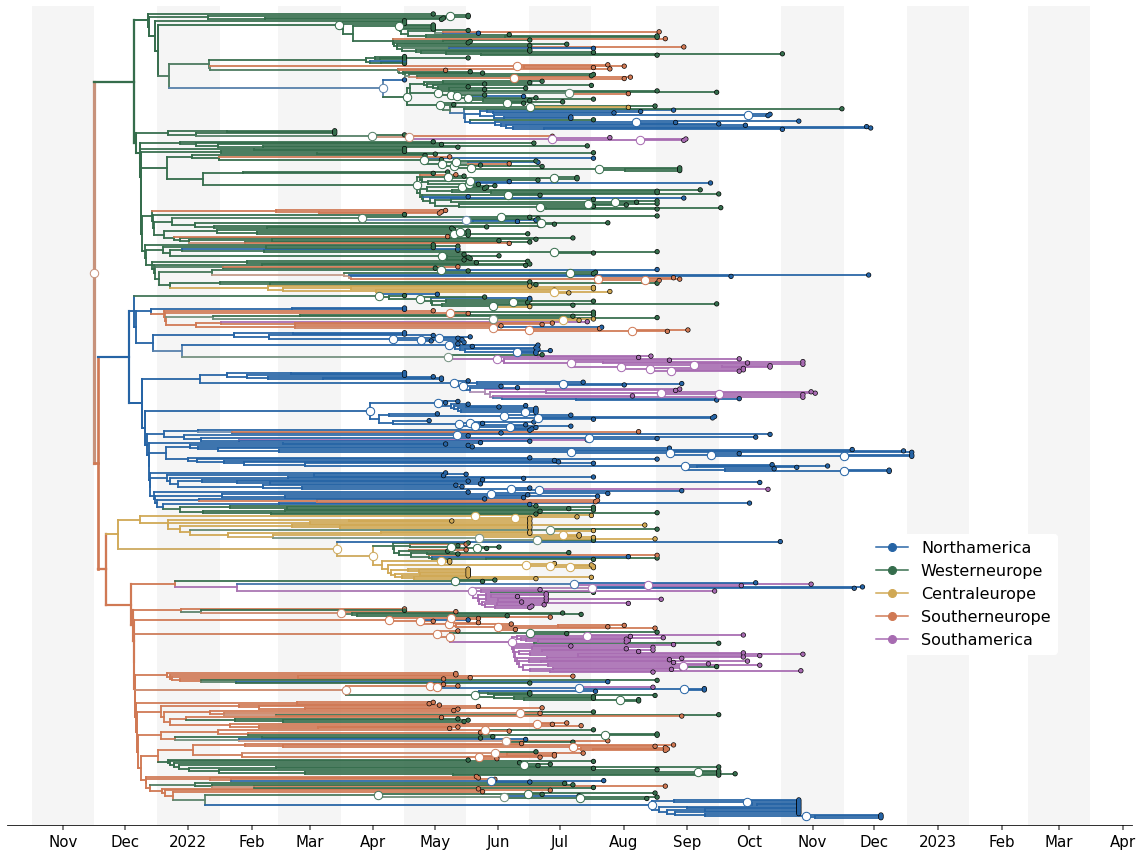

In [8]:
fig,ax = plt.subplots(figsize=(16,12),facecolor='w')



branchWidth=1.75 ## default branch width
tipSize = 15

# k objects are tips, nodes, branches
for k in tree.Objects: ## iterate over objects in tree
    x=k.absoluteTime ## or use absolute time instead
    y=k.y 
    
    xp=k.parent.absoluteTime ## get x position of current object's parent
    if x==None: ## matplotlib won't plot Nones, like root
        x=0.0
    if xp==None:
        xp=x
    
    if isinstance(k,bt.leaf) or k.branchType=='leaf': ## if leaf...
        base_color=colors[metadata[k]["division"]]
        color_ramp = clr.LinearSegmentedColormap.from_list('custom ', [uncertainty_color,base_color], N=256)
        c = color_ramp(node_probs[k])
        s=tipSize
        
        ax.scatter(x,y,s=s,facecolor=c,edgecolor='none',zorder=11) ## plot circle for every tip
        ax.scatter(x,y,s=s+0.8*s,facecolor='k',edgecolor='none',zorder=10) ## plot black circle underneath
    
    elif isinstance(k,bt.node) or k.branchType=='node': ## if node...
        number_children = len(k.leaves)
        node_branchwidth = branchWidth + number_children*0.0025
        base_color=colors[node_types[k]["division"]]
        color_ramp = clr.LinearSegmentedColormap.from_list('custom ', [uncertainty_color, base_color], N=256)
        c = color_ramp(node_probs[k])
        ax.plot([x,x],[k.children[-1].y,k.children[0].y],lw=node_branchwidth,color=c,ls='-',zorder=9) #color=node_colors[node_types[k]["node_community_status"]]
        if k.traits['posterior']>=0.5:
            ax.scatter(x,y,s=70,facecolor='w',edgecolor=c,zorder=100)
    ax.plot([xp,x],[y,y],lw=node_branchwidth,color=c,ls='-',zorder=9)
        
    # add in a legend
    han_list = []

    # bbox to anchor puts a bounding box around where you want the legend to go, prop part is for text size
for key in division_order:
    marker = mlines.Line2D(range(1), range(1), color = colors[key], marker='o', markerfacecolor = colors[key], label = key.replace("_"," ").title(), markersize = 8)
    han_list.append(marker)

# ax3 = fig.add_axes([0.716, 0.75, 0.16, 0.2])
# ax3.hist(pos_support, alpha = 0.7)
# #ax.hist(pos_support, 50, density=True, facecolor='g', alpha=0.75)    
# ax3.spines['left'].set_visible(False)
# #ax.spines['right'].set_visible(False)
# ax3.spines['top'].set_visible(False) 
# ax3.set_xlabel("Posterior Node Support", size=10)
# ax3.set_ylabel("Count", size=15)
# ax3.tick_params(axis='x',labelsize=10,size=0)    

xDates=['%04d-%02d-01'%(y,m) for y in range(2021,2024) for m in range(1,13)]

every=1
[ax.axvspan(bt.decimalDate(xDates[x]),bt.decimalDate(xDates[x])+1/float(12),facecolor='k',edgecolor='none',alpha=0.04) for x in range(0,len(xDates),2)]
ax.set_xticks([bt.decimalDate(x)+1/24.0 for x in xDates if (int(x.split('-')[1])-1)%every==0])

ax.set_xticklabels([convertDate(x,'%Y-%m-%d','%Y') if x.split('-')[1]=='01' else convertDate(x,'%Y-%m-%d','%b') for x in xDates if (int(x.split('-')[1])-1)%every==0])
ax.tick_params(axis='x',labelsize=16,size=0)    
    
# set axis limits, remove border lines         
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
#ax.spines['bottom'].set_visible(False)

ax.set_ylim(-5,tree.ySpan+5)
ax.set_xlim(2021.8,2023.3)
ax.tick_params(axis='y',labelsize=0,size=0)
ax.tick_params(axis='x',labelsize=15,size=5, width=2,color='grey')
   # set date labels every 4
ax.set_yticklabels([])

# in order to get the legend to plot without being transparent, over the plot, it needs to be here with frame set to true
# bbox arguments are: x, y, with 0 being furthest left and bottom
ax.legend(handles = han_list, markerfirst = True, edgecolor="white", framealpha=1, bbox_to_anchor=[0.76, 0.20], loc=3,prop={'size': 16}, facecolor='w')

fig.tight_layout()
#plt.gcf().subplots_adjust(right=0.88)
plt.savefig('../figures/mcc_glm_region_300.png',dpi=300,bbox_inches='tight')

plt.show()

In [139]:
key_order = {"NorthAmerica":1,
"WesternEurope":2,
"CentralEurope":3,
"SouthernEurope":4,
"SouthAmerica":5,

                
                 }

#division_order = [ 'NorthAmerica', "WesternEurope", 'CentralEurope', "SouthernEurope", 'SouthAmerica' ]

In [140]:
def enumerate_subtrees(tree):
    
    traitName="max"

    tree.root.traits[traitName]='ancestor' ## give root node some trait value that's different from what the actual tree root has, so it registers as a switch

    tree_strings={division:[] for division in division_order}
    subtype_trees={division:[] for division in division_order}

    for k in sorted(tree.Objects,key=lambda x:x.height):
        kp=k.parent     # kp is the parent node of k

        ## get current node's (k) and its parent's (kp) trait states
        kloc=k.traits[traitName]      # kloc = trait of k; kc = trait of k; they are the same thing
        if traitName in k.parent.traits:       # if parent has a trait block, use that trait, else assign to ancestor
            kploc=kp.traits[traitName]              # kploc = trait of parental node
        else:
            kploc='ancestor'

        kc=kloc     
        ## if states do not match
        if kloc!=kploc:      # if node and parental node do not have the same trait
            #N_children=len(k.leaves)
            traverse_condition=lambda w:w.traits[traitName]==kloc     # traverse tree for all nodes whose traitname = kc
            #print('subtree resulting from %s>%s switch, traversing within %s'%(kploc,kloc,kloc))
            subtree=tree.subtree(k,traverse_condition=traverse_condition) #traitName = traitName ## this function returns a new baltic object that contains a trait-traversed subtree, starting from node k, for as long as the traversal stays within the starting trait value state

            if subtree != None:
                subtree.traverse_tree()
                subtree.sortBranches()
                tree_strings[kloc].append(subtree.toString()) ## remember subtree string, subtree object itself
                subtype_trees[kloc].append((kploc,subtree))
    
    return(subtype_trees)

In [141]:
def plot_exploded_tree_no_cases(subtype_trees2, filename, width, height):
    
    mpl.rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
    mpl.rc('text', usetex='false') 
    mpl.rcParams.update({'font.size': 22})
    
    fig,ax1 = plt.subplots(figsize=(width,height),facecolor='w')

    traitName='max'
    tipSize=20
    mpl.rcParams['font.size']=16
    cumulative_y=0
    cutoff = 2022.1
    origin_size=150


    


    for i in reversed(sorted(subtype_trees2.keys(), key=lambda x:key_order[x])):
        starting_y = cumulative_y
        cumulative_y+=10
        for subtree in subtype_trees2[i]:
            #print(tr) ## iterate over trait values
            origin = subtree[0]
            loc_tree = subtree[1]
            min_node_x = min(k.absoluteTime for k in loc_tree.Objects)
            



            # count number of total leaves
            number_tips = 0
            for k in loc_tree.Objects:
                if k.branchType == "leaf":
                    number_tips += 1

            """ Iterate through each object in the subtree, and plot a dot for each tip, and lines connecting them
            for each node. Do this for all except the horizontal line connecting the origin and the subtee"""
            for k in loc_tree.Objects:

                xp= k.parent.absoluteTime
                x = k.absoluteTime
                y = k.y + cumulative_y
                c = colors[k.traits[traitName]]
                s = tipSize
                a = k.traits["max.prob"]

                if k.branchType == "leaf":
                    ax1.scatter(x,y,s=tipSize,facecolor=c, alpha=a,edgecolor="black",zorder=100) ## plot tip circle
                    ax1.scatter(x,y,s=tipSize,facecolor="black", alpha=a,edgecolor="black",zorder=99)

                elif k.branchType == "node": 
                    # this plots the vertical lines connecting children and parents on tree
                    ax1.plot([x,x],[k.children[-1].y + cumulative_y,k.children[0].y+ cumulative_y],lw=branchWidth,color=c,alpha=a,ls='-',zorder=9)            

               # if xp != loc_tree.root.absoluteTime:  # don't plot line connecting subtree to origin
        
                ax1.plot([xp, x],[y,y],lw=branchWidth,color=c,ls='-',zorder=9)   # this connects horizontal tree lines
#                     else:
#                         ax1.plot([x,cutoff],[y,y],"-",lw=branchWidth,color=c,zorder=9)   # this connects horizontal tree lines
                
                        
                        
                        
            """ Plot a colored circle at the origin, and plot a line connecting that circle to the subtree. Make 
            that line be dotted or solid depending on how far back the origin is and how far back the node is"""
            # first, plot the origin circle
       # first, plot the origin circle
            oriC = colors[origin]

            oriX=loc_tree.root.parent.absoluteTime
            oriY=loc_tree.root.y+cumulative_y
            ax1.scatter(oriX,oriY,s=origin_size,facecolor=oriC,edgecolor='k',lw=1,zorder=200) ## add big circle at base of tree to indicate origin



#             #plot dotted line connecting circle to tree 
#             if min_node_x < cutoff: # whole thing before cutoff, whole thing dotted
#                 ax1.plot([oriX, min_node_x],[oriY,oriY], ":", color=c,lw=branchWidth,zorder=98)

#             elif oriX < cutoff: # partly before 2016, partial dotteds
#                 ax1.plot([cutoff, min_node_x],[oriY,oriY],"-",color=c,lw=branchWidth,zorder=98)
#                 ax1.plot([cutoff,oriX],[oriY,oriY],":",color=c,lw=branchWidth,zorder=98)

#             else:
 #           ax1.plot([oriX, min_node_x],[oriY,oriY],":",color=c,lw=branchWidth,zorder=98)
            
            cumulative_y+=loc_tree.ySpan+8 
        oriC = colors[i]
        ending_y = cumulative_y
        ax1.axhspan(ending_y, starting_y, facecolor=oriC, alpha = 0.2)
        

    #add in a legend
    han_list = []
    for key in division_order:
        marker = mlines.Line2D(range(1), range(1), color = colors[key], marker='o', markerfacecolor = colors[key], label = key.replace("_"," ").title(), markersize = 8)
        han_list.append(marker)
    ax1.legend(handles = han_list, markerfirst = True, edgecolor="white", bbox_to_anchor=[1, 0.15], loc=3, prop={'size': 14}, facecolor='w')
    #lgd = ax.legend(handles = han_list, markerfirst = True, frameon=True, edgecolor="white", bbox_to_anchor=[0.9, 0.15], loc=3, prop={'size': 16}, title=legend_title, title_fontsize=16)
    xDates=['%04d-%02d-01'%(y,m) for y in range(2021,2024) for m in range(1,13)]


    every=1
#     [ax1.axvspan(bt.decimalDate(xDates[x]),bt.decimalDate(xDates[x])+1/float(12),facecolor='k',edgecolor='none',alpha=0.04) for x in range(0,len(xDates),2)]
    ax1.set_xticks([bt.decimalDate(x)+1/24.0 for x in xDates if (int(x.split('-')[1])-1)%every==0])

    ax1.set_xticklabels([convertDate(x,'%Y-%m-%d','%Y') if x.split('-')[1]=='01' else convertDate(x,'%Y-%m-%d','%b') for x in xDates if (int(x.split('-')[1])-1)%every==0])
    ax1.tick_params(axis='x',labelsize=16,size=0)  

    #ax1.xaxis.tick_bottom()
    ax1.yaxis.tick_left()

    [ax1.spines[loc].set_visible(False) for loc in ['top','right','left']]

    ax1.tick_params(axis='y',size=0)
    ax1.set_yticklabels([])
    ax1.set_ylim(-5,cumulative_y)
    ax1.set_xlim(2021.8,2023.1)

    plt.savefig(filename,bbox_inches = 'tight',pad_inches = 0)
    plt.show()

In [142]:

subtype_trees2 = enumerate_subtrees(tree)


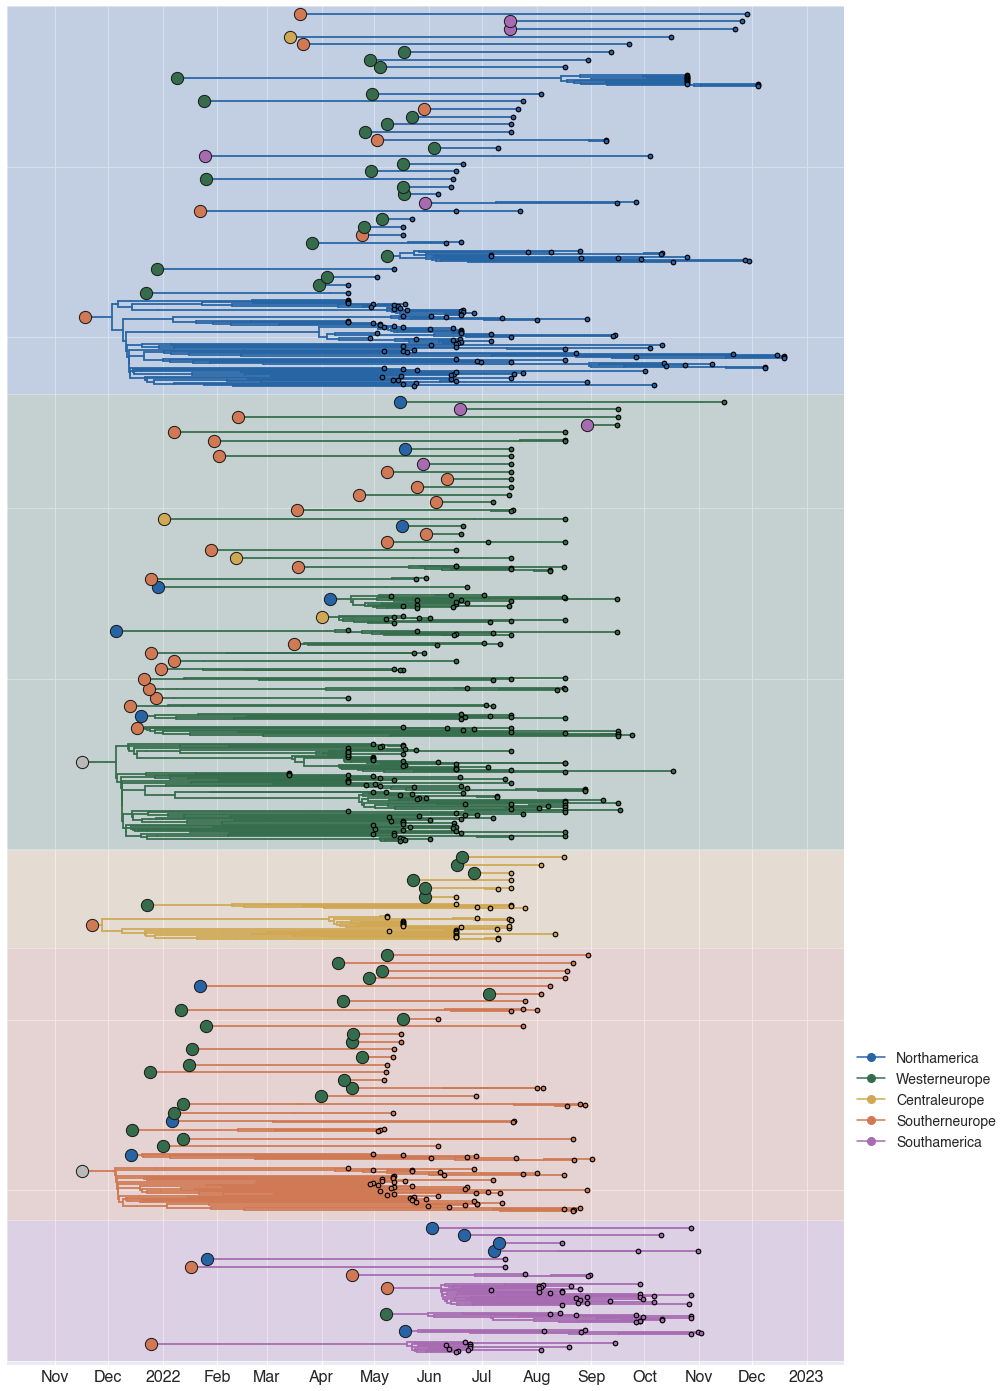

In [143]:

exploded_tree_output_file_name2 = "../figures/test_region_glm.png"

plot_exploded_tree_no_cases(subtype_trees2, exploded_tree_output_file_name2,15,25)  # dotted lines, no case counts


In [43]:
region = {'Canada':'NorthAmerica',
          'United States':'NorthAmerica',
         'Finland':'NorthernEurope',
           'Austria': 'WesternEurope',
        'Germany':'WesternEurope', 
        'Switzerland':'WesternEurope',
         'United Kingdom':'WesternEurope',
        'France':'WesternEurope',
        'Belgium':'WesternEurope',
        'Netherlands':'WesternEurope',
        'Slovakia':'CentralEurope',
        'Slovenia':'CentralEurope',
        'Italy':'SouthernEurope',
        'Portugal':'SouthernEurope',
        'Spain':'SouthernEurope',
         'Colombia':'SouthAmerica',
          
        'Peru':'SouthAmerica'}

In [44]:
def foo_plot_exploded_tree_with_cases(subtype_trees2, filename, width, height, division_level):
    
    raw_cases = pd.read_csv("../case-rt-analysis/data/monkeypox-cases-counts.tsv", sep="\t")
    #print(raw_cases[raw_cases.location =="United Kingdom"])
    raw_cases.location[raw_cases["location"] == "United States"] = "USA"
    raw_cases.location[raw_cases["location"] == "United Kingdom"] = "UnitedKingdom"
    #print(raw_cases.location.value_counts())
    raw_cases["region"] = np.nan
    raw_cases.region = raw_cases.location.map(region)
    raw_cases.date = raw_cases.date.astype('datetime64[ns]')
    #print(raw_cases.location.value_counts())

    if division_level == "region":
        raw_cases = raw_cases.dropna()

        weekly_data = raw_cases.groupby("region").resample('W-Wed', label='right', closed = 'right', on='date').sum().reset_index().sort_values(by=["region","date"])    
        weekly_data["d_date"] = weekly_data['date'].astype("str").apply(lambda x:bt.decimalDate(x) )
    elif division_level =="country":
        weekly_data = raw_cases.groupby("location").resample('W-Wed', label='right', closed = 'right', on='date').sum().reset_index().sort_values(by=["location","date"])    
        weekly_data["d_date"] = weekly_data['date'].astype("str").apply(lambda x:bt.decimalDate(x) )
        
            
    heights={division:[] for division in division_order}

    mpl.rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
    mpl.rc('text', usetex='false') 
    mpl.rcParams.update({'font.size': 22})
    
    fig,ax1 = plt.subplots(figsize=(width,height),facecolor='w')
    #ax2 = ax1.twinx()

    traitName='max'
    tipSize=20
    mpl.rcParams['font.size']=16
    cumulative_y=0
    cutoff = 2022.1
    origin_size=100
    cum_bar = 0


    


    for i in reversed(sorted(subtype_trees2.keys(), key=lambda x:key_order[x])):
        starting_y = cumulative_y
        cumulative_y+=10
        for subtree in subtype_trees2[i]:
            #print(tr) ## iterate over trait values
            origin = subtree[0]
            loc_tree = subtree[1]
            min_node_x = min(k.absoluteTime for k in loc_tree.Objects)
            



            # count number of total leaves
            number_tips = 0
            for k in loc_tree.Objects:
                if k.branchType == "leaf":
                    number_tips += 1

            """ Iterate through each object in the subtree, and plot a dot for each tip, and lines connecting them
            for each node. Do this for all except the horizontal line connecting the origin and the subtee"""
            for k in loc_tree.Objects:

                xp= k.parent.absoluteTime
                x = k.absoluteTime
                y = k.y + cumulative_y
                c = colors[k.traits[traitName]]
                s = tipSize
                a = k.traits["max.prob"]

                if k.branchType == "leaf":
                    ax1.scatter(x,y,s=tipSize,facecolor=c, alpha=a,edgecolor="black",zorder=100) ## plot tip circle
                    ax1.scatter(x,y,s=tipSize,facecolor="black", alpha=a,edgecolor="black",zorder=99)

                elif k.branchType == "node": 
                    # this plots the vertical lines connecting children and parents on tree
                    ax1.plot([x,x],[k.children[-1].y + cumulative_y,k.children[0].y+ cumulative_y],lw=branchWidth,color=c,alpha=a,ls='-',zorder=9)            
                    if k.traits['posterior']>=0.5:
                        ax1.scatter(x,y,s=70,facecolor='w',edgecolor=c,zorder=100)
                ax1.plot([xp, x],[y,y],lw=branchWidth,color=c,ls='-',zorder=9)   # this connects horizontal tree lines
                
                        
                        
                        
            """ Plot a colored circle at the origin, and plot a line connecting that circle to the subtree. Make 
            that line be dotted or solid depending on how far back the origin is and how far back the node is"""
            # first, plot the origin circle
            oriC = colors[origin]

            oriX=loc_tree.root.parent.absoluteTime
            oriY=loc_tree.root.y+cumulative_y
            if loc_tree.root.parent.traits['posterior']>=0.5:
                ax1.scatter(oriX,oriY,s=origin_size*2,facecolor=oriC,edgecolor='w',lw=2,zorder=200) ## add big circle at base of tree to indicate origin
            else:
                ax1.scatter(oriX,oriY,s=origin_size*0.5,facecolor=oriC,edgecolor='k',lw=1,zorder=200) ## add big circle at base of tree to indicate origin


            
            cumulative_y+=loc_tree.ySpan+8 
        oriC = colors[i]
        ending_y = cumulative_y
        ax1.axhspan(ending_y, starting_y, facecolor=oriC, alpha = 0.15)
        heights[i].append((starting_y, ending_y))

    #overlay country cases    
    for i in reversed(sorted(subtype_trees2.keys(), key=lambda x:key_order[x])):
        start = heights[i][0][0]
        end = heights[i][0][1]
        #print(i)
        if division_level == "region":
            x = weekly_data.loc[weekly_data['region'] == i, "d_date"]
            cases = weekly_data.loc[weekly_data['region'] == i, "cases"]
        elif division_level =="country":
            x = weekly_data.loc[weekly_data['location'] == i, "d_date"]
            cases = weekly_data.loc[weekly_data['location'] == i, "cases"]        
        
        test = ((cases- (min(cases)))/(max(cases)-min(cases)))
        y1 = (((cases- (min(cases)))/(max(cases)-min(cases))) *(end- start))
        testprop= ((end-start)/cumulative_y)
        
        if division_level == "region":
            ax1.bar(x, (y1), color=colors[i], width = 0.01,  alpha = 0.3, bottom = start)

        elif division_level =="country":
            ax1.bar(x, (y1), color=colors[i], width = 0.01,  alpha = 0.3, bottom = start)

            #ax1.xaxis_date()
    #add in a legend
    han_list = []
    for key in division_order:
        marker = mlines.Line2D(range(1), range(1), color = colors[key], marker='o', markerfacecolor = colors[key], label = key.replace("_"," ").title(), markersize = 8)
        han_list.append(marker)
    ax1.legend(handles = han_list, markerfirst = True, edgecolor="white", bbox_to_anchor=[1, 0.15], loc=3, prop={'size': 14}, facecolor='w')
    #lgd = ax.legend(handles = han_list, markerfirst = True, frameon=True, edgecolor="white", bbox_to_anchor=[0.9, 0.15], loc=3, prop={'size': 16}, title=legend_title, title_fontsize=16)
    xDates=['%04d-%02d-01'%(y,m) for y in range(2021,2024) for m in range(1,13)]


    every=1
#     [ax1.axvspan(bt.decimalDate(xDates[x]),bt.decimalDate(xDates[x])+1/float(12),facecolor='k',edgecolor='none',alpha=0.04) for x in range(0,len(xDates),2)]
    ax1.set_xticks([bt.decimalDate(x)+1/24.0 for x in xDates if (int(x.split('-')[1])-1)%every==0])

    ax1.set_xticklabels([convertDate(x,'%Y-%m-%d','%Y') if x.split('-')[1]=='01' else convertDate(x,'%Y-%m-%d','%b') for x in xDates if (int(x.split('-')[1])-1)%every==0])
    ax1.tick_params(axis='x',labelsize=16,size=0)  

    #ax1.xaxis.tick_bottom()
    ax1.yaxis.tick_left()

    [ax1.spines[loc].set_visible(False) for loc in ['top','right','left']]

    ax1.tick_params(axis='y',size=0)
    ax1.set_yticklabels([])
    ax1.set_ylim(-5,cumulative_y)
    ax1.set_xlim(2021.8,2023.1)

    plt.savefig(filename,bbox_inches = 'tight',pad_inches = 0)
    plt.show()

/var/folders/h9/0347drb57tsgxzbddmvmlvf80000gp/T/ipykernel_43456/422693563.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  raw_cases.location[raw_cases["location"] == "United States"] = "USA"
/var/folders/h9/0347drb57tsgxzbddmvmlvf80000gp/T/ipykernel_43456/422693563.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  raw_cases.location[raw_cases["location"] == "United Kingdom"] = "UnitedKingdom"


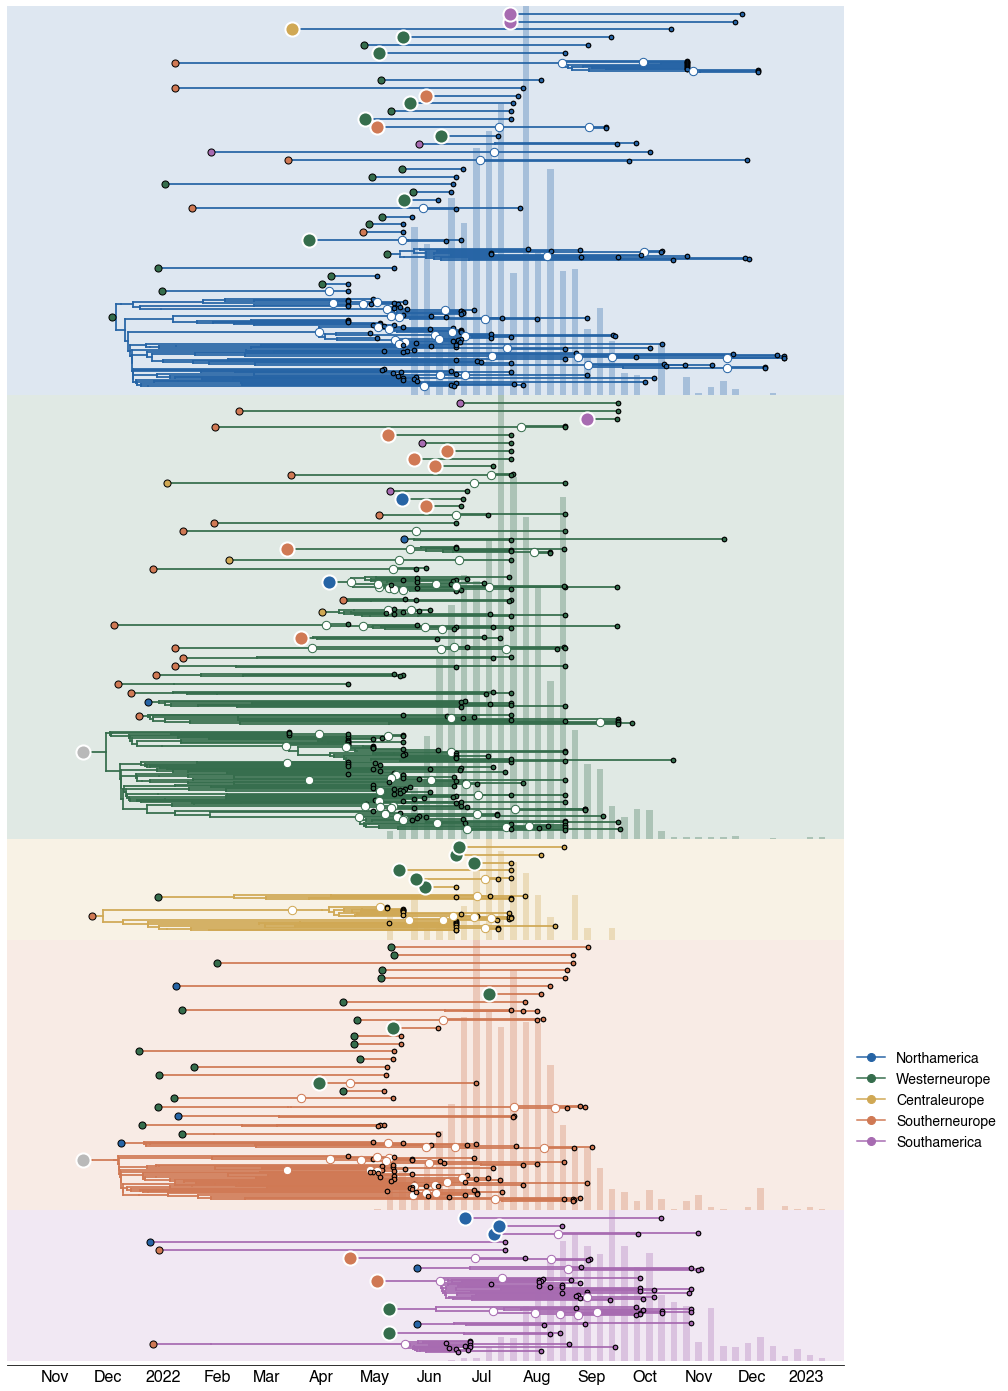

In [45]:
exploded_tree_output_file_name4 = "../figures/550_region_glm_cases_exploded_air.png"

foo_plot_exploded_tree_with_cases(subtype_trees2, exploded_tree_output_file_name4,15,25, "region")  # dotted lines, no case counts


## plot glm country tree

In [ ]:
# set path to tree to load 
tree_path = "/Users/mparedes/Desktop/mpox_rhino/300_glm_country_mcc.tree"

In [ ]:
# load trees
tree = bt.loadNexus(tree_path, tip_regex='_([0-9\-]+)$')
tree.setAbsoluteTime(2023.0068)

In [ ]:
# add together probabilities for divisions in the same regions

# parse leaf and node information into a dictionary for plotting
metadata = {}
node_types = {}
node_probs = {}
pos_support = []


for k in tree.Objects: ## iterate over objects in tree
    if k.branchType=='leaf':
        division = k.traits['max']
        #region = regions[division]
        metadata[k] = {}
        metadata[k]["division"] = division
        #metadata[k]["region"] = region
        node_probs[k] = k.traits["max.prob"]  # for a leaf, this is always 1.0
    
    # parse the nodes now and pick out the type trait
    if k.branchType=='node':
        node_division = k.traits["max"]
        division_prob = k.traits["max.prob"]
        
        #node_region = regions[node_division]       
        geo_set = k.traits['max.set']
        geo_set_prob = k.traits['max.set.prob']
        
        node_prob = 0
        for i in range(len(geo_set)):
            division = geo_set[i]
            #region = regions[division]
            geo_prob = geo_set_prob[i]
            
            #if region == node_region:
            node_prob += geo_prob
        
        
        node_types[k] = {}
        node_types[k]["division"] = node_division
        #node_types[k]["region"] = node_region 
        node_probs[k] = division_prob
        pos_support.append(k.traits["posterior"])
        #division_probs[k] = division_prob
        #print(node_probs[k])

In [ ]:
colors = {"Canada":"#133253",
          "USA":"#2664A5",
        
          
          # greens
          "UnitedKingdom":"#1C3828",
          "Germany":"#356D4C",
          "Switzerland":"#81A48F",
          "Austria":"#B3C8BC",
          "France":"#CCDAD2",

          "Belgium":"#438B62",
          #"Netherlands":"#60B684",

          
          # yellows
          "Slovakia":"#D0A854",
          "Slovenia":"#EEC060",

          
          # oranges
          "Italy":"#D07954",
          "Portugal":"#EEA160",
          "Spain":"#F4C49C",
          
          # purples
          "Colombia":"#2D1E45",
          "Peru":"#695B82",
          "ancestor":'grey'

          
          # reds

          #"Finland":"#C5656E"
         }

uncertainty_color = "#B9B9B9"

division_order = ["Canada",
"USA",
"UnitedKingdom",
"Germany",
"Switzerland",
"Austria",
"France",
"Belgium",
#"Netherlands",
"Slovakia",
"Slovenia",
"Italy",
"Portugal",
"Spain",
"Colombia",
"Peru"
#"Finland"
                
] 

key_order = {"Canada":1,
"USA":2,
"UnitedKingdom":3,
"Germany":4,
"Switzerland":5,
"Austria":6,
"France":7,
"Belgium":8,
#"Netherlands",
"Slovakia":9,
"Slovenia":10,
"Italy":11,
"Portugal":12,
"Spain":13,
"Colombia":14,
"Peru":15
#"Finland"
                
                 }

In [ ]:
fig,ax = plt.subplots(figsize=(15,12),facecolor='w')



branchWidth=1.75 ## default branch width
tipSize = 15

# k objects are tips, nodes, branches
for k in tree.Objects: ## iterate over objects in tree
    x=k.absoluteTime ## or use absolute time instead
    y=k.y 
    
    xp=k.parent.absoluteTime ## get x position of current object's parent
    if x==None: ## matplotlib won't plot Nones, like root
        x=0.0
    if xp==None:
        xp=x
    
    if isinstance(k,bt.leaf) or k.branchType=='leaf': ## if leaf...
        base_color=colors[metadata[k]["division"]]
        color_ramp = clr.LinearSegmentedColormap.from_list('custom ', [uncertainty_color,base_color], N=256)
        c = color_ramp(node_probs[k])
        s=tipSize
        
        ax.scatter(x,y,s=s,facecolor=c,edgecolor='none',zorder=11) ## plot circle for every tip
        ax.scatter(x,y,s=s+0.8*s,facecolor='k',edgecolor='none',zorder=10) ## plot black circle underneath
    
    elif isinstance(k,bt.node) or k.branchType=='node': ## if node...
        number_children = len(k.leaves)
        node_branchwidth = branchWidth + number_children*0.0025
        base_color=colors[node_types[k]["division"]]
        color_ramp = clr.LinearSegmentedColormap.from_list('custom ', [uncertainty_color, base_color], N=256)
        c = color_ramp(node_probs[k])
        ax.plot([x,x],[k.children[-1].y,k.children[0].y],lw=node_branchwidth,color=c,ls='-',zorder=9) #color=node_colors[node_types[k]["node_community_status"]]
        if k.traits['posterior']>=0.5:
            ax.scatter(x,y,s=70,facecolor='w',edgecolor=c,zorder=100)
    ax.plot([xp,x],[y,y],lw=node_branchwidth,color=c,ls='-',zorder=9)
        
    # add in a legend
    han_list = []

    # bbox to anchor puts a bounding box around where you want the legend to go, prop part is for text size
for key in division_order:
    marker = mlines.Line2D(range(1), range(1), color = colors[key], marker='o', markerfacecolor = colors[key], label = key.replace("_"," ").title(), markersize = 8)
    han_list.append(marker)

ax3 = fig.add_axes([0.716, 0.75, 0.16, 0.2])
ax3.hist(pos_support, alpha = 0.7)
#ax.hist(pos_support, 50, density=True, facecolor='g', alpha=0.75)    
ax3.spines['left'].set_visible(False)
#ax.spines['right'].set_visible(False)
ax3.spines['top'].set_visible(False) 
ax3.set_xlabel("Posterior Node Support", size=10)
ax3.set_ylabel("Count", size=15)
ax3.tick_params(axis='x',labelsize=10,size=0)    

ax3.tick_params(axis='y',labelsize=10,size=0)  
xDates=['%04d-%02d-01'%(y,m) for y in range(2021,2024) for m in range(1,13)]

every=1
[ax.axvspan(bt.decimalDate(xDates[x]),bt.decimalDate(xDates[x])+1/float(12),facecolor='k',edgecolor='none',alpha=0.04) for x in range(0,len(xDates),2)]
ax.set_xticks([bt.decimalDate(x)+1/24.0 for x in xDates if (int(x.split('-')[1])-1)%every==0])

ax.set_xticklabels([convertDate(x,'%Y-%m-%d','%Y') if x.split('-')[1]=='01' else convertDate(x,'%Y-%m-%d','%b') for x in xDates if (int(x.split('-')[1])-1)%every==0])
ax.tick_params(axis='x',labelsize=16,size=0)    
    
# set axis limits, remove border lines         
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
#ax.spines['bottom'].set_visible(False)

ax.set_ylim(-5,tree.ySpan+5)
ax.set_xlim(2021.8,2023.4)
ax.tick_params(axis='y',labelsize=0,size=0)
ax.tick_params(axis='x',labelsize=15,size=5, width=2,color='grey')
   # set date labels every 4
ax.set_yticklabels([])

# in order to get the legend to plot without being transparent, over the plot, it needs to be here with frame set to true
# bbox arguments are: x, y, with 0 being furthest left and bottom
ax.legend(handles = han_list, markerfirst = True, edgecolor="white", framealpha=1, bbox_to_anchor=[0.75, 0.20], loc=3,prop={'size': 16}, facecolor='w')

fig.tight_layout()
plt.gcf().subplots_adjust(right=0.88)
plt.savefig('../figures/mcc_glm_country_300.png',dpi=300,bbox_inches='tight')

plt.show()

In [ ]:

subtype_trees2 = enumerate_subtrees(tree)

exploded_tree_output_file_name2 = "../figures/300_country_glm_exploted.png"

plot_exploded_tree_no_cases(subtype_trees2, exploded_tree_output_file_name2,15,25)  # dotted lines, no case counts


In [ ]:
exploded_tree_output_file_name4 = "../figures/300_country_glm_cases_exploded.png"

foo_plot_exploded_tree_with_cases(subtype_trees2, exploded_tree_output_file_name4,15,25, "country")  # dotted lines, no case counts
